In [89]:
#Hiperparámetros
n_posiciones = 2
n_cajas = 2

# Funciones

## Cálculo de parámetros

In [90]:
import string

# Lista con los númreos de las posiciones. Ej: [1,2,3]
posiciones = list(range(1,n_posiciones+1))

# String con los nombres de las cajas. Ej: "ABCD"
cajas = string.ascii_uppercase[:n_cajas]

# Cálculo del número de operaciones distintas
# Ir     -> (posiciones - ultima_posicion) a derecha + (posiciones - primera_posicion) a izquierda = 2*(posiciones - 1)
# Mover  -> ir llevando una de las cajas = 2*(n_posiciones - 1) x cajas
# Coger  -> cada caja en cada posicion = cajas x posiciones
# Apilar -> cada caja en cada posicion sobre una de las otras cajas o sobre el suelo = cajas x posiciones x (cajas - 1 + suelo'1') = cajas x cajas x posiciones
max_operaciones = 2*(n_posiciones-1) + 2*(n_posiciones-1)*n_cajas + n_posiciones*n_cajas + n_cajas*n_cajas*n_posiciones

# Cálculo de bits de la máscara
# bits para posiciones   -> (cajas + gancho) x posiciones
# bits para apilamientos -> cajas x (cajas-1 + posiciones) x2(S/N)
# bits para libres       -> (cajas + gancho) x2(S/N)
bits_mascara = (n_cajas + 1)*n_posiciones + n_cajas*(n_cajas + n_posiciones - 1)*2 + (n_cajas + 1)*2

print(f"Posiciones: {posiciones}")
print(f"Cajas: {cajas}")
print("Nº operaciones máximas: ", max_operaciones)
print("Nº bits máscara: ", bits_mascara)

Posiciones: [1, 2]
Cajas: AB
Nº operaciones máximas:  18
Nº bits máscara:  24


In [91]:
#-------------------------------------------------------------------------------------------
# Cálculo de bases (Ejemplo con 4 cajas y 3 posiciones)
#--------------------------------------------------------------------------------------------
# |    posiciones    |        (cjX/cjY)          |        ~(cjX/cjY)         |  Libre(S/N)  |
#  G   A   B   C   D    A      B      C      D      A      B      C      D    G  A  B  C  D
# 321 321 321 321 321 BCD123 ACD123 ABD123 ABC123 BCD123 ACD123 ABD123 ABC123 SN SN SN SN SN
# 000_000_000_000_000_000000_000000_000000_000000_000000_000000_000000_000000_00_00_00_00_00
#    ^               ^                           ^                           ^              ^
# base(pos_g)  base(pos_cajas)               base(apila)               base(noapila) base(libres)
#-------------------------------------------------------------------------------

# Bases cajas libres / no_libres
base_cajas_no_libres         = 2**0
base_caja_no_libre           = lambda idx_caja : base_cajas_no_libres * 2**((n_cajas-idx_caja-1)*2)
base_caja_libre              = lambda idx_caja : base_caja_no_libre(idx_caja) * 2

# Bases de gancho libre
base_gancho_no_libre         = 2**((n_cajas)*2)
base_gancho_libre            = base_gancho_no_libre * 2

# Bases de cajaX no está sobre cajaY o suelo
base_no_apilamientos         = 2**((n_cajas + 1)*2)
base_no_apilamientos_caja    = lambda idx_caja : base_no_apilamientos * ((2**(n_cajas + n_posiciones - 1))**(n_cajas-idx_caja-1))
aux_indice                   = lambda idx_caja1, idx_caja2: n_cajas + n_posiciones - idx_caja2 - 2 if idx_caja1 > idx_caja2 else n_cajas + n_posiciones - idx_caja2 - 1
base_caja1_no_sobre_caja2    = lambda idx_caja1, idx_caja2 : base_no_apilamientos_caja(idx_caja1) * (2**aux_indice(idx_caja1, idx_caja2))
base_caja_no_sobre_posicion  = lambda idx_caja, posicion : base_no_apilamientos_caja(idx_caja) * (2**(n_posiciones - posicion))


# Bases de cajaX está sobre cajaY o suelo
base_apilamientos            = 2**((n_cajas + 1)*2 + (n_cajas*(n_cajas + n_posiciones - 1)))
base_apilamientos_caja       = lambda idx_caja : base_apilamientos * ((2**(n_cajas + n_posiciones - 1))**(n_cajas-idx_caja-1))
base_caja1_sobre_caja2       = lambda idx_caja1, idx_caja2 : base_apilamientos_caja(idx_caja1) * (2**aux_indice(idx_caja1, idx_caja2))
base_caja_sobre_posicion     = lambda idx_caja, posicion : base_apilamientos_caja(idx_caja) * (2**(n_posiciones - posicion))

# Bases de la posicion de las cajas
base_pos_cajas               = 2**((n_cajas + 1)*2 + (n_cajas*(n_cajas + n_posiciones - 1))*2)
base_pos_caja                = lambda idx_caja : base_pos_cajas * ((2**n_posiciones)**(n_cajas-idx_caja-1))
base_esta_caja_posicion      = lambda idx_caja, posicion : base_pos_caja(idx_caja) * 2**(posicion-1)

# Base de la posición del gancho
base_pos_g                   = 2**((n_cajas + 1)*2 + (n_cajas*(n_cajas + n_posiciones - 1))*2 + n_cajas*n_posiciones)
base_esta_gancho_posicion    = lambda posicion: base_pos_g * 2**(posicion-1)

# Máscara de unos para eliminar estados
e_mask = 2**(bits_mascara)-1


## Creación y visualización de máscaras

In [92]:
# Función que crea una máscara respecto de un vector
def mascara(vector):

  # Se identifican los valores del vector referentes a posiciones
  vector_posiciones = vector[:n_cajas+1]
  # Se identifican los valores del vector referentes a apilamientos de cajas
  vector_apilamientos = vector[n_cajas+1:]

  # Se enmascara la Posición de G
  mascara = 2**(vector_posiciones[0]-1) #Posición de G
  #print(f"Enmascarada posición de G")

  # Se enmascara la posición de las cajas
  for idx, caja in enumerate(cajas):
    mascara *= 2**(n_posiciones)
    mascara += 2**(vector_posiciones[idx+1]-1) #Posición de cada caja
    #print(f"Enmascarada posición de {caja}")

  # Se enmascaran que cajas están encima de otras y sobre las posiciones
  mascara_no_apilamientos = []
  for idx_caja, caja_superior in enumerate(cajas):
    flag_caja_esta_sobre_otra = False

    # Se enmascara sobre que otra caja está cada caja
    for caja_inferior in cajas.replace(caja_superior, ""):
      mascara *= 2
      if caja_superior+caja_inferior in vector_apilamientos:
        mascara += 1
        mascara_no_apilamientos.append(0)
        flag_caja_esta_sobre_otra = True
      else:
        mascara_no_apilamientos.append(1)

    # Se enmascara en que posición está la caja si está en el suelo
    for posicion in posiciones:
      mascara *= 2
      if not flag_caja_esta_sobre_otra and vector_posiciones[idx_caja+1] == posicion:
        mascara +=1
        mascara_no_apilamientos.append(0)
      else:
        mascara_no_apilamientos.append(1)

  # Se enmascaran que cajas no están encima de otras o sobre el suelo
  for bit in mascara_no_apilamientos:
    mascara *= 2
    mascara += bit

  # Se enmascara que el gancho y las cajas están libres #10(G)-10(A)-10(B)-10(C)-...
  for i in range(n_cajas+1):
    mascara *= 4
    mascara += 2

  return mascara


# Función que permite visualizar la máscara
def mostrar(valor):

  if isinstance(valor, int):
    valor = bin(valor)

  #Se quita el 0b y se añaden los 0s restantes por delante
  mascara = valor[2:].zfill(bits_mascara)

  #Se separa la máscara por grupos
  mascara_posiciones = mascara[:(1+n_cajas)*n_posiciones]
  mascara_apilamientos = mascara[(1+n_cajas)*n_posiciones:-(1+n_cajas)*2]
  mascara_libres = mascara[-(1+n_cajas)*2:]

  #Se añaden guiones para separar subgrupos
  mascara_posiciones = '_'.join([mascara_posiciones[i:i+n_posiciones] for i in range(0, len(mascara_posiciones), n_posiciones)])
  mascara_apilamientos = '_'.join([mascara_apilamientos[i:i+n_cajas+n_posiciones-1] for i in range(0, len(mascara_apilamientos), n_cajas+n_posiciones-1)])
  mascara_libres = '_'.join([mascara_libres[i:i+2] for i in range(0, len(mascara_libres), 2)])

  #Se añaden guiones para separar grupos
  mascara = "_".join([mascara_posiciones, mascara_apilamientos, mascara_libres])

  return mascara

In [93]:
#Ejemplo del uso de las funciones anteriores para 4 cajas y 3 posiciones
vectorInicial = [1, 1, 1, 1, 1, 'BA', 'AC', 'CD']
vectorMeta=[3, 3, 3, 3, 3, 'AB', 'BC', 'CD']

print("VECTOR INICIAL:", vectorInicial)
print("\n____posiciones________________sobre______________________no_sobre____________libres_s/n___")
print("_G___A___B___C___D____A______B______C______D______A______B______C______D____G__A__B__C__D_")
print(mostrar(mascara(vectorInicial)))

print("\nVECTOR META:", vectorMeta)
print("\n____posiciones________________sobre______________________no_sobre____________libres_s/n___")
print("_G___A___B___C___D____A______B______C______D______A______B______C______D____G__A__B__C__D_")
print(mostrar(mascara(vectorMeta)))

VECTOR INICIAL: [1, 1, 1, 1, 1, 'BA', 'AC', 'CD']

____posiciones________________sobre______________________no_sobre____________libres_s/n___
_G___A___B___C___D____A______B______C______D______A______B______C______D____G__A__B__C__D_
01_01_01_010_100_101_011_10_10_10

VECTOR META: [3, 3, 3, 3, 3, 'AB', 'BC', 'CD']

____posiciones________________sobre______________________no_sobre____________libres_s/n___
_G___A___B___C___D____A______B______C______D______A______B______C______D____G__A__B__C__D_
10_10_10_010_000_001_111_1_10_10_10


## Crear Operaciones

### Operaciones tipo IR

In [94]:
#------------------------------------------------------------------------------
# OPERACIONES DE TIPO IR
#------------------------------------------------------------------------------
def definir_acciones_ir(posiciones, cajas):

  # Creamos listas vacías para las distintas partes de una operacion
  acciones, PC, E, A = [], [], [], []

  # Definimos operaciones en ambos sentidos entre cada posición y la siguiente
  for posicion in posiciones[:-1]:

#-------------------------------------------------------------------------------

    acciones.append(f"Ir(G,{posicion},{posicion+1})")

    #PC -> Está(G,posicion), Libre(G)
    PC.append(base_esta_gancho_posicion(posicion) + base_gancho_libre)

    #E -> Está(G,posicion)
    E.append(e_mask - base_esta_gancho_posicion(posicion))

    #A -> Está (G,posicion+1)
    A.append(base_esta_gancho_posicion(posicion+1))

#-------------------------------------------------------------------------------

    acciones.append(f"Ir(G,{posicion+1},{posicion})")

    #PC -> Está(G,posicion+1), Libre(G)
    PC.append(base_esta_gancho_posicion(posicion+1) + base_gancho_libre)

    #E -> Está(G,posicion+1)
    E.append(e_mask - base_esta_gancho_posicion(posicion+1))

    #A -> Está (G,posicion)
    A.append(base_esta_gancho_posicion(posicion))

#-------------------------------------------------------------------------------

  return acciones, PC, E, A

# Código para mostrar las operaciones de forma independiente
#acc,pc,e,a = definir_acciones_ir(posiciones, cajas)
#for i in range(len(acc)):
#  print(f"[{i}] {acc[i]}")
#  print("PC:", mostrar(pc[i]))
#  print("E: ", mostrar(e[i]))
#  print("A: ", mostrar(a[i]))

### Operaciones tipo MOVER

In [95]:
#------------------------------------------------------------------------------
# OPERACIONES DE TIPO MOVER
#------------------------------------------------------------------------------
def definir_acciones_mover(posiciones, cajas):

  # Creamos listas vacías para las distintas partes de una operacion
  acciones, PC, E, A = [], [], [], []

  # Definimos operaciones para cada caja
  for idx_caja, caja in enumerate(cajas):
    # Definimos operaciones en ambos sentidos entre cada posición y la siguiente
    for posicion in posiciones[:-1]:

#-------------------------------------------------------------------------------

      acciones.append(f"Mover(G,{caja},{posicion},{posicion+1})")

      #PC -> Está(G,posicion), Está(caja,posicion), NoLibre(G), NoLibre(caja)
      PC.append(base_esta_gancho_posicion(posicion) +
                base_esta_caja_posicion(idx_caja, posicion) +
                base_gancho_no_libre +
                base_caja_no_libre(idx_caja))

      #E -> Está(G,posicion), Está(caja,posicion)
      E.append(e_mask - base_esta_gancho_posicion(posicion) -
               base_esta_caja_posicion(idx_caja, posicion))

      #A -> Está(G,posicion+1), Está(caja,posicion+1)
      A.append(base_esta_gancho_posicion(posicion+1) +
               base_esta_caja_posicion(idx_caja, posicion+1))

#-------------------------------------------------------------------------------

      acciones.append(f"Mover(G,{caja},{posicion+1},{posicion})")

      #PC -> Está(G,posicion+1), Está(caja,posicion+1), NoLibre(G), NoLibre(caja)
      PC.append(base_esta_gancho_posicion(posicion+1) +
                base_esta_caja_posicion(idx_caja, posicion+1) +
                base_gancho_no_libre +
                base_caja_no_libre(idx_caja))

      #E -> Está(G,posicion+1), Está(caja,posicion+1)
      E.append(e_mask - base_esta_gancho_posicion(posicion+1) -
               base_esta_caja_posicion(idx_caja, posicion+1))

      #A -> Está(G,posicion), Está(caja,posicion)
      A.append(base_esta_gancho_posicion(posicion) +
               base_esta_caja_posicion(idx_caja, posicion))

#-------------------------------------------------------------------------------

  return acciones, PC, E, A

# Muestra las operaciones de forma independiente
#acc,pc,e,a = definir_acciones_mover(posiciones, cajas)
#for i in range(len(acc)):
#  print(f"[{i}] {acc[i]}")
#  print("PC:", mostrar(pc[i]))
#  print("E: ", mostrar(e[i]))
#  print("A: ", mostrar(a[i]))

### Operaciones tipo  COGER

In [96]:
#------------------------------------------------------------------------------
# OPERACIONES DE TIPO COGER
#------------------------------------------------------------------------------
def definir_acciones_coger(posiciones, cajas):

  # Creamos listas vacías para las distintas partes de una operacion
  acciones, PC, E, A = [], [], [], []

  # Definimos operaciones para cada caja
  for idx_caja, caja in enumerate(cajas):
    # Definimos operaciones para cada posicion
    for posicion in posiciones:

#-------------------------------------------------------------------------------

      acciones.append(f"Coger(G,{caja},{posicion})")

      #PC -> Está(G,posicion), Esta(caja,posicion), Libre(G), Libre(caja), NoSobre(Otrascajas*, caja)
      pc = base_esta_gancho_posicion(posicion) + base_esta_caja_posicion(idx_caja, posicion) + base_gancho_libre + base_caja_libre(idx_caja)
      #Se comprueba que la caja no está debajo de ninguna otra
      for idx_superior, caja_superior in enumerate(cajas):
        if (idx_caja == idx_superior):
          continue
        pc += base_caja1_no_sobre_caja2(idx_superior, idx_caja)
      PC.append(pc)

      #E -> Libre(G), Libre(caja), Sobre(caja, Otrascajas*)
      e = base_gancho_libre + base_caja_libre(idx_caja)
      # Eliminar los estados de la caja sobre las otras cajas y las posiciones
      for idx_inferior in range(n_cajas+n_posiciones-1):
        e += base_apilamientos_caja(idx_caja) * (2**idx_inferior)
      E.append(e_mask - e)

      #A -> NoLibre(G), NoLibre(caja), NoSobre (caja, Otrascajas*)
      a = base_gancho_no_libre + base_caja_no_libre(idx_caja)
      # Añade los estados de la caja no sobre las otras cajas ni el suelo
      for idx_inferior in range(n_cajas+n_posiciones-1):
        a += base_no_apilamientos_caja(idx_caja) * (2**idx_inferior)
      A.append(a)

#-------------------------------------------------------------------------------

  return acciones, PC, E, A

# Muestra las operaciones de forma independiente
#acc,pc,e,a = definir_acciones_coger(posiciones, cajas)
#for i in range(len(acc)):
#  print(f"[{i}] {acc[i]}")
#  print("PC:", mostrar(pc[i]))
#  print("E: ", mostrar(e[i]))
#  print("A: ", mostrar(a[i]))

### Operaciones tipo APILAR

In [97]:
#------------------------------------------------------------------------------
# OPERACIONES DE TIPO APILAR
#------------------------------------------------------------------------------
def definir_acciones_apilar(posiciones, cajas):

  # Creamos listas vacías para las distintas partes de una operacion
  acciones, PC, E, A = [], [], [], []

  # Definimos operaciones para cada caja
  for idx_caja, caja in enumerate(cajas):
    # Definimos operaciones para cada posicion
    for posicion in posiciones:
      # Definimos operaciones para las otras cajas
      for idx_inferior, caja_inferior in enumerate(cajas):
        if (idx_caja == idx_inferior):
            continue

#-------------------------------------------------------------------------------

        acciones.append(f"Apilar(G,{caja},{caja_inferior},{posicion})")

        #PC -> Está(G,posicion), Está(caja,posicion), Está(caja_inferior,posicion), NoLibre(G), NoLibre(caja), NoSobre(Otrascajas*, caja_inferior)
        pc_aux = 0
        #Se comprueba que la caja sobre la que se va a colocar no está debajo de ninguna otra
        for idx_superior, caja_superior in enumerate(cajas):
          if (idx_inferior == idx_superior):
            continue
          pc_aux += base_caja1_no_sobre_caja2(idx_superior, idx_inferior)
        PC.append(base_esta_gancho_posicion(posicion) + base_esta_caja_posicion(idx_caja, posicion) +
                  base_esta_caja_posicion(idx_inferior, posicion) + base_gancho_no_libre +
                  base_caja_no_libre(idx_caja) + pc_aux)

        #E -> NoLibre(G), NoLibre(caja), Nosobre(caja, caja_inferior)
        E.append(e_mask - base_gancho_no_libre - base_caja_no_libre(idx_caja) - base_caja1_no_sobre_caja2(idx_caja, idx_inferior))

        #A -> Libre(G), Libre(caja), Sobre(caja, caja_inferior)
        A.append(base_gancho_libre + base_caja_libre(idx_caja) + base_caja1_sobre_caja2(idx_caja, idx_inferior))

#-------------------------------------------------------------------------------

      acciones.append(f"Apilar(G,{caja},{posicion})")

      #PC -> Está(G,posicion), Está(caja,posicion), NoLibre(G), NoLibre(caja), NoSobre(cajas*, posicion)
      pc_aux = 0
      #Se comprueba que noy cajas sobre esa posición donde se va a colocar la caja
      for idx_superior, caja_superior in enumerate(cajas):
        pc_aux += base_caja_no_sobre_posicion(idx_superior, posicion)
      PC.append(base_esta_gancho_posicion(posicion) + base_esta_caja_posicion(idx_caja, posicion) +
                base_gancho_no_libre + base_caja_no_libre(idx_caja) + pc_aux)

      #E -> NoLibre(G), NoLibre(caja), NoSobre(caja, posicion)
      E.append(e_mask - base_gancho_no_libre - base_caja_no_libre(idx_caja) - base_caja_no_sobre_posicion(idx_caja, posicion))

      #A -> Libre(G), Libre(caja), Sobre(caja, posicion)
      A.append(base_gancho_libre + base_caja_libre(idx_caja) + base_caja_sobre_posicion(idx_caja, posicion))

#-------------------------------------------------------------------------------

  return acciones, PC, E, A

# Muestra las operaciones de forma independiente
#acc,pc,e,a = definir_acciones_apilar(posiciones, cajas)
#for i in range(len(acc)):
#  print(f"[{i}] {acc[i]}")
#  print("PC:", mostrar(pc[i]))
#  print("E: ", mostrar(e[i]))
#  print("A: ", mostrar(a[i]))

### Concatenación de operaciones

In [98]:
#------------------------------------------------------------------------------
# CONCATENACION DE OPERACIONES
#------------------------------------------------------------------------------
def definir_acciones(posiciones, cajas):

  # Creamos listas vacías para las distintas partes de una operacion
  acciones, PC, E, A = [], [], [], []

  acciones_ir, PC_ir, E_ir, A_ir =  definir_acciones_ir(posiciones, cajas)
  acciones_coger, PC_coger, E_coger, A_coger =  definir_acciones_coger(posiciones, cajas)
  acciones_mover, PC_mover, E_mover, A_mover =  definir_acciones_mover(posiciones, cajas)
  acciones_apilar, PC_apilar, E_apilar, A_apilar =  definir_acciones_apilar(posiciones, cajas)

  acciones += acciones_coger + acciones_mover + acciones_apilar + acciones_ir
  PC += PC_coger + PC_mover + PC_apilar + PC_ir
  E = E_coger + E_mover + E_apilar + E_ir
  A += A_coger + A_mover + A_apilar + A_ir

  return acciones, PC, E, A

len(definir_acciones(posiciones, cajas))
texto, PC, E, A = definir_acciones(posiciones, cajas)

for i in range(len(texto)):
  print(f"[{i}] {texto[i]}")
  print("PC:", mostrar(PC[i]))
  print("E: ", mostrar(E[i]))
  print("A: ", mostrar(A[i]))

[0] Coger(G,A,1)
PC: 01_01_00_000_000_000_100_10_10_00
E:  11_11_11_000_111_111_111_01_01_11
A:  00_00_00_000_000_111_000_01_01_00
[1] Coger(G,A,2)
PC: 10_10_00_000_000_000_100_10_10_00
E:  11_11_11_000_111_111_111_01_01_11
A:  00_00_00_000_000_111_000_01_01_00
[2] Coger(G,B,1)
PC: 01_00_01_000_000_100_000_10_00_10
E:  11_11_11_111_000_111_111_01_11_01
A:  00_00_00_000_000_000_111_01_00_01
[3] Coger(G,B,2)
PC: 10_00_10_000_000_100_000_10_00_10
E:  11_11_11_111_000_111_111_01_11_01
A:  00_00_00_000_000_000_111_01_00_01
[4] Mover(G,A,1,2)
PC: 01_01_00_000_000_000_000_01_01_00
E:  10_10_11_111_111_111_111_11_11_11
A:  10_10_00_000_000_000_000_00_00_00
[5] Mover(G,A,2,1)
PC: 10_10_00_000_000_000_000_01_01_00
E:  01_01_11_111_111_111_111_11_11_11
A:  01_01_00_000_000_000_000_00_00_00
[6] Mover(G,B,1,2)
PC: 01_00_01_000_000_000_000_01_00_01
E:  10_11_10_111_111_111_111_11_11_11
A:  10_00_10_000_000_000_000_00_00_00
[7] Mover(G,B,2,1)
PC: 10_00_10_000_000_000_000_01_00_01
E:  01_11_01_111_111

## Planificación

### Función de transición

Actualiza el estado del mundo después de realizar una acción.

In [107]:
#Función de transición
def intentar(nodo,op):

    #print("intentar", texto[op], end=" -> ")
    #print(f"precondiciones [{op}] ->", mostrar(PC[op]))
    #print("nodo_actual_estado ->", mostrar(nodo))

    if (bin(nodo & PC[op]) == bin(PC[op])): # Cumple las PC para aplicar la op

        siguiente=int(bin(nodo & E[op]),2) # Eliminamos propiedades E
        siguiente=int(bin(siguiente | A[op]),2) # Añade propiedades A

        #print("Se cumplen las precondiciones")
        #print("se quita ->", mostrar(E[op]))
        #print("se añade ->", mostrar(A[op]))
        #print("act_estado ->", mostrar(nodo))
        #print("sig_estado ->", mostrar(siguiente))
        #print("Se cumplen las precondiciones")

    else:
        #print("No se cumplen las precondiciones")
        siguiente=-1

    return siguiente

### Función de comprobación de estados repetidos en la pila

In [108]:
#Función de comprobación de estados en la pila
def encontrado(siguiente, indice_pila, estado):

    #print("Comprobando estados:")
    encontrado=False
    t=indice_pila
    while (t>=0):
        if (estado[t]==siguiente):
          #print("Estado repetido en posicion", t,  "-->", mostrar(estado[t]))
          encontrado=True
        t-=1

    #if not encontrado:
      #print("No se ha encontrado coincidencias en la pila de estados")

    return encontrado

### Función de planificación

Función que utiliza STRIPS para planificar una secuencia de acciones que conduce del estado inicial al estado objetivo.

In [109]:
from __future__ import print_function
def resolver(inicial, meta, max_profundidad):

  estado = [0]*max_profundidad
  operaciones = [0]*max_profundidad

  # Cima de la pila
  indice_pila = 0
  estado[indice_pila]=inicial
  operaciones[indice_pila]=0 # Las operaciones van desde 0 hasta max_operaciones-1
  op = 0
  actual = inicial

  # Mientras queden estados por explorar
  while (indice_pila>=0):

    #print(indice_pila, "Retorno a estado:", mostrar(actual))

    while ((op<max_operaciones) and (indice_pila<max_profundidad-1) and (actual!=meta)):

          # Intenta realizar la acción op sobre el estado actual
        siguiente=intentar(actual,op)

        # Si se han cumplido las precondiciones se procesa el nuevo estado.
        if (siguiente!=-1): # -1 es null acción no permitida

            # Si el estado no está en la pila se guarda y se avanza a la siguiente posición
            if (not(encontrado(siguiente, indice_pila, estado))):

                # Mantenemos en la pila el estado y la acción incrementando el índice en 1

                #print ("se profundiza -> pila", indice_pila)
                indice_pila+=1

                estado[indice_pila]=actual
                operaciones[indice_pila]=op

                #print(indice_pila,texto[operaciones[indice_pila]],'-->',mostrar(estado[indice_pila]),end='\n')
                # Saltamos al siguiente estado
                actual=siguiente
                op=-1 # Para que empiece en 0

                print("INICIO-->", end="")
                for t in range(1,indice_pila+1):
                  print(f"{texto[operaciones[t]]}-->",end='')
                print("FIN")

                if (int(bin(actual & meta),2)==int(bin(meta),2)):
                  return operaciones[1:indice_pila+1]
        op+=1

    # Si se han probado todas las operaciones para un estado se retrocede al anterior
    actual=estado[indice_pila]
    # Se continuan las operaciones en la siguiente a la que se había utilizado para avanzar
    op=operaciones[indice_pila]+1
    indice_pila -= 1

  return []

# Ejecución

In [118]:
max_profundidad=31
#vectorInicial = [1, 1, 1, 1, 1, 'BA', 'AC', 'CD']
#vectorMeta = [1, 1, 2, 1, 2, 'AC', 'DB']
#vectorMeta=[3, 3, 3, 3, 3, 'AB', 'BC', 'CD']

#Ejemplo con 3 cajas
#vectorInicial = [1, 1, 1, 1, 'AB', 'CA']
#vectorMeta = [3, 1, 2, 3]

#Ejemplo con 2 cajas
vectorInicial = [1, 1, 1,'AB']
vectorMeta = [1, 2, 1]

inicial = mascara(vectorInicial)
meta = mascara(vectorMeta)

print("Profundidad:", max_profundidad)
print("Estado inicial",  mostrar(inicial))
print("Estado final  ",  mostrar(meta))
print("------------------------------------------------------------------------------------------------------------------\n")

operaciones = resolver(inicial, meta, max_profundidad)

if operaciones:
  print("SOLUCIÓN:")

  print("INICIO-->", end="")
  for t in range(len(operaciones)):
    print(f"{texto[operaciones[t]]}-->",end='')
  print("FIN")
else:
  print("No se ha encontrado una solución")

Profundidad: 31
Estado inicial 01_01_01_100_010_011_101_10_10_10
Estado final   01_10_01_001_010_110_101_10_10_10
------------------------------------------------------------------------------------------------------------------

INICIO-->Coger(G,A,1)-->FIN
INICIO-->Coger(G,A,1)-->Mover(G,A,1,2)-->FIN
INICIO-->Coger(G,A,1)-->Mover(G,A,1,2)-->Apilar(G,A,2)-->FIN
INICIO-->Coger(G,A,1)-->Mover(G,A,1,2)-->Apilar(G,A,2)-->Ir(G,2,1)-->FIN
SOLUCIÓN:
INICIO-->Coger(G,A,1)-->Mover(G,A,1,2)-->Apilar(G,A,2)-->Ir(G,2,1)-->FIN


## Visualización

Profundidad: 31
Estado inicial 01_01_01_100_010_011_101_10_10_10
Estado final   01_10_01_001_010_110_101_10_10_10
------------------------------------------------------------------------------------------------------------------



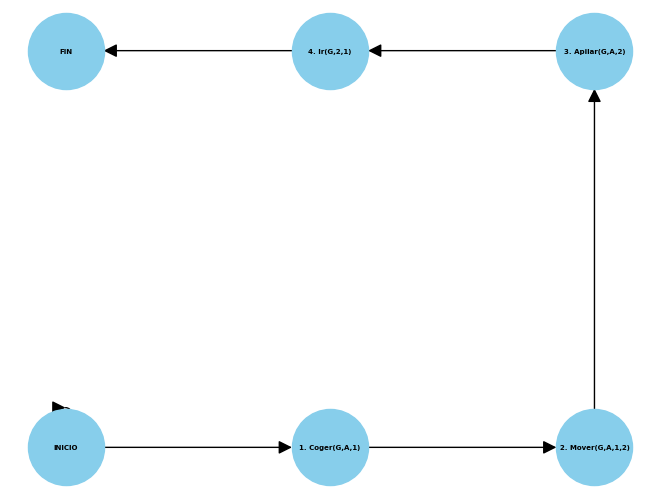

In [119]:
import networkx as nx
import matplotlib.pyplot as plt
from math import sqrt, ceil

print("Profundidad:", max_profundidad)
print("Estado inicial",  mostrar(inicial))
print("Estado final  ",  mostrar(meta))
print("------------------------------------------------------------------------------------------------------------------\n")

if operaciones:

  nodos = [texto[i] for i in operaciones]
  nodos = [str(i+1) + ". " + nodos[i] for i in range(len(nodos))]
  nodos.insert(0, "INICIO")
  nodos.append("FIN")

  edges = [("INICIO", nodos[0])]
  for i in range(len(operaciones)):
    edges.append((nodos[i], nodos[i+1]))
  edges.append((nodos[len(operaciones)], "FIN"))

  # Define el grafo de acciones
  grafo_acciones = nx.DiGraph()

  grafo_acciones.add_edges_from(edges)
  # Visualiza el grafo de acciones
  #posiciones_nodos = nx.circular_layout(grafo_acciones)
  dim = ceil(sqrt(len(nodos)))
  col = lambda x: x%dim
  row = lambda x: x//dim
  posiciones_nodos = {nodo: (col(i) if row(i)%2 == 0 else dim-col(i)-1, row(i)) for i, nodo in enumerate(nodos)}

  nx.draw(grafo_acciones, pos=posiciones_nodos, with_labels=True, node_size=3000, node_color="skyblue", font_size=5, font_color="black", font_weight="bold", arrowsize=20)
  plt.show()
else:
  print("No se ha encontrado una solución")

# Pruebas

In [ ]:
def intentar(nodo,op):

    print("intentar", texto[op])
    print(f"precondiciones [{op}] ->", mostrar(PC[op]))
    print("nodo_actual_estado ->", mostrar(nodo))

    if (int(bin(nodo & PC[op]),2)==int(bin(PC[op]),2)): # Cumple las PC para aplicar la op
        print("Se cumplen las precondiciones")
        print("se quita ->", mostrar(E[op]))
        print("se añade ->", mostrar(A[op]))
        siguiente=int(bin(nodo & E[op]),2) # Eliminamos propiedades E
        siguiente=int(bin(siguiente | A[op]),2) # Añade propiedades A
        print("nodo_actual_estado ->", mostrar(nodo))
        print("nodo_siguiente_est ->", mostrar(siguiente))
    else:
        print("No se cumplen las precondiciones")
        siguiente=-1

    print("\n-----------------------------------------\n")
    return siguiente

estado_actual = inicial

acciones_prueba = "Coger(G,B,1)-->Mover(G,B,1,2)-->Apilar(G,B,2)-->Ir(G,2,1)-->Coger(G,A,1)-->Mover(G,A,1,2)-->Apilar(G,A,B,2)-->Ir(G,2,1)-->Coger(G,C,1)-->Mover(G,C,1,2)-->Apilar(G,C,A,2)-->Ir(G,2,1)-->Coger(G,D,1)"+"-->Mover(G,D,1,2)-->Mover(G,D,2,3)-->Apilar(G,D,3)-->Ir(G,3,2)-->Coger(G,C,2)-->Mover(G,C,2,3)-->Apilar(G,C,D,3)-->Ir(G,3,2)-->Coger(G,A,2)-->Mover(G,A,2,1)-->Apilar(G,A,1)-->Ir(G,1,2)-->Coger(G,B,2)-->Mover(G,B,2,3)"+"-->Apilar(G,B,C,3)-->Ir(G,3,2)-->Ir(G,2,1)-->Coger(G,A,1)-->Mover(G,A,1,2)-->Mover(G,A,2,3)-->Apilar(G,A,B,3)"
acciones_prueba = acciones_prueba.split("-->")

for accion_prueba in acciones_prueba:
  indice = texto.index(accion_prueba)
  check = intentar(estado_actual, indice)
  if check != -1:
    estado_actual = check

estado_final = meta
print("Compruebación")
print("Esperado: ", mostrar(estado_final))
print("Calculado:", mostrar(estado_actual))
print(estado_final == estado_actual)
